In [1]:
#IMPORTING LIBRARIES

from IPython.display import clear_output
import import_ipynb
from matplotlib import pylab as plt
import numpy as np
import os
import torch
from torch import nn

from utils import *

device = torch.device("cpu")

In [4]:
"""This class produces an instance of our problem statement:
a set of images, that need to be ranked."""

class Instance:
    
    def __init__(self, dir, dims):
        
        files = [file for file in os.listdir(dir) if file.endswith('.png')]
        self.files = files
        self.size = len(files)
        self.imagetensors = torch.zeros((self.size, 3, dims[0], dims[1]))
        self.images = {}
        
        for i, file in enumerate(files):
            
            path = os.path.join(dir, file)
            imagetensor = tensor_from_image(path, dims)
            imagetensor = imagetensor.to(device)
            self.imagetensors[i] = imagetensor
            N, H, W = imagetensor.size()
            imagetensor = imagetensor.view((1, N, H, W))
            self.images[file] = imagetensor
            
    def __iter__(self):
        
        for file, imagetensor in zip(self.files, self.imagetensors):
            yield file, imagetensor
    
#         imagetensor = nn.Flatten()(imagetensor)
    def __getitem__(self, idx):
        
        return self.files[idx], self.imagetensors[idx] 
    
    def display(self, idx):
        
        print(self.files[idx])
        imagetensor = self.imagetensors[idx]
        imagematrix = imagetensor.cpu()
        imagematrix = imagetensor.numpy()
        imagematrix = np.transpose(imagematrix, (1, 2, 0))
        imagematrix = np.int32(imagematrix)
        plt.imshow(imagematrix)
    
# SAMPLE USAGE
"""Please uncomment the lines below to test a sample execution of this class
(Select the concerned lines and press Ctrl + '/')"""
clear_output()


# instance = Instance('./novel_images/', (224, 224))
# instance.display(0)

In [5]:
def distance(image1, image2, model, dist_function=nn.PairwiseDistance(p=2)):
    
    _, imagetensor1 = image1
    _, imagetensor2 = image2
    
    N, H, W = imagetensor1.size()
    imagetensor1 = imagetensor1.view((1, N, H, W))
    imagetensor2 = imagetensor2.view((1, N, H, W))
    
    imagetensor1 = model(imagetensor1)
    imagetensor2 = model(imagetensor2)
    
    distance = dist_function(imagetensor1, imagetensor2)
    
    return distance.item()
   
"""This function calculates the distance of a given image 'key' from
each of the other images that together form the instance"""

def distances(key, instance, model, dist_function=nn.PairwiseDistance(p=2)):
    
    distances = []
    
    for example in instance:

        distances.append(distance(key, example, model))
        
    return distances

# SAMPLE USAGE

# model = network()
# instance = Instance('./novel_images/', (224, 224))
# example = instance[0]
# print(model(example[1].view((1, 3, 224, 224))))
# print(model(example[1].view((1, 3, 224, 224))))

# print(distances(example, instance, model))

In [6]:
"""The 'score' of a given image has been formulated as the sum total of its distances
from all the other images in the instance.
Hence, unique images end up getting the highest scores"""

def score(key, instance, model):
    
    return sum(distances(key, instance, model))


"""This function constructs a dictionary of scores and sorts it"""
def sorted_score_tuples(instance, model):
    
    score_tuples = []
    for example in instance:
        
        name = example[0]
        current_score = score(example, instance, model)
        score_tuples.append((name, current_score))
    
    score_tuples = sorted(score_tuples, key=lambda x : x[1])
    
    return score_tuples


# SAMPLE USAGE
# print(score(example, instance, model))
# score_tuples = sorted_score_tuples(instance, model)
# print(score_tuples)
# print(score_tuples[-1])

['natalieportman2.png', 'dog1.png', 'dog3.png']
[['natalieportman2.png', 'keanureeves1.png', 'natalieportman1.png', 'keanureeves4.png', 'bradpitt2.png', 'man1.png', 'dog2.png', 'keanureeves3.png'], ['dog1.png'], ['dog3.png']]
Cluster 1


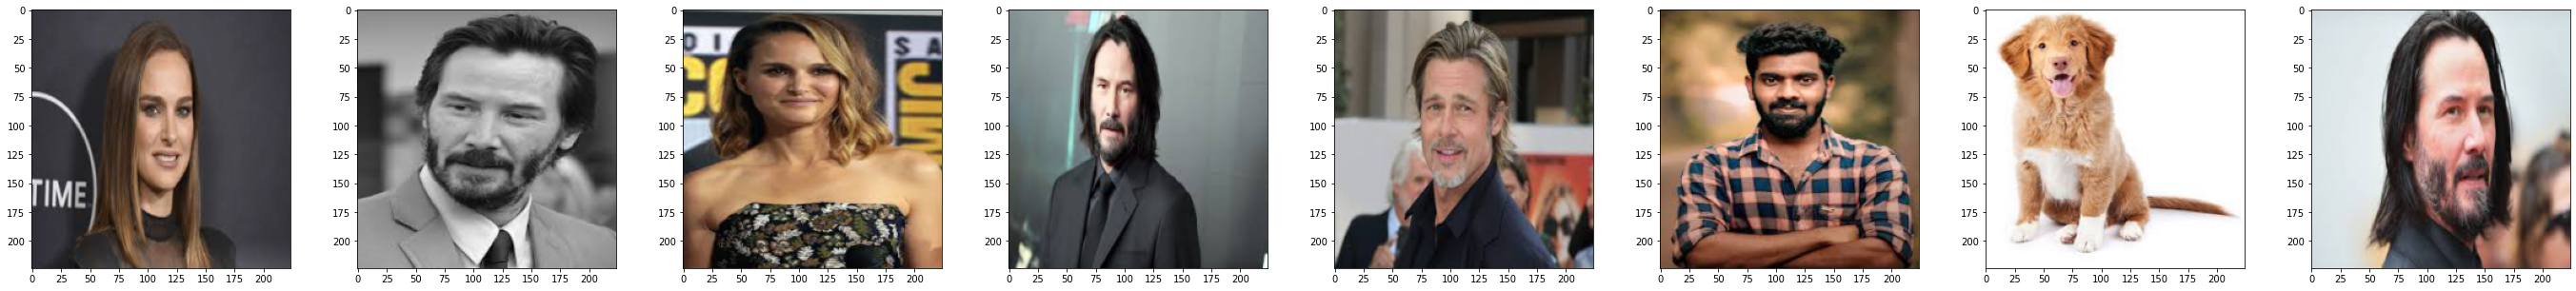

Cluster 2


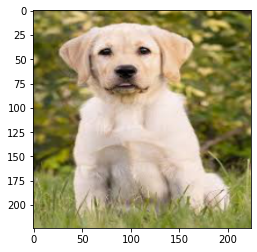

Cluster 3


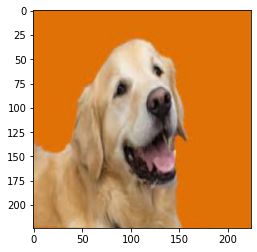

In [15]:
"""This class will handle all clustering operartions. 
Similar images will be grouped together and a list of clusters will
be displayed

Arguments:
instance: An object of the class Instance
model:  The neural network which will be used for clustering
k: the desired number of clusters

NOTE: The code below needs optimization; a more efficient clustering algorithm will be rolled out at some point"""

class Clustering:
    
    def __init__(self, instance, model, k, dist_function=nn.PairwiseDistance(p=2), dims=(3, 224, 224)):
                
        score_tuples = sorted_score_tuples(instance, model)
        seeds = [score_tuples[0][0]]
        
        
#         for i in range(1, k+1, 1):
#             seeds.append(score_tuples[-i][0])
        temp = set([tuple[0] for tuple in score_tuples])
        temp.remove(seeds[0])
        
        for i in range(k-1):
            next_seed = list(temp)[0]
            max_dist = 0
    
            for file in temp:
                imagetensor = instance.images[file]
                imagetensor = model(imagetensor)
                d = 0

                for seed in seeds:

                    seedtensor = instance.images[seed]
                    seedtensor = model(seedtensor)
                    d += dist_function(imagetensor, seedtensor)

                if d > max_dist:
                    max_dist = d
                    next_seed = file

            seeds.append(next_seed)
            temp.remove(next_seed)
#         print(seeds)
        self.seeds = seeds   
        self.clusters = [[seed] for seed in seeds]
        
        seed_tensors = torch.zeros((k, 4096))
        
        for i in range(k):
            seed_tensors[i] = model(instance.images[seeds[i]])
            
        N = instance.size
        
        for j, key in enumerate(instance.images.keys()):
            
            keytensor = instance.images[key]
            keytensor = model(keytensor)
            min_dist_idx = 0
            min_dist = dist_function(keytensor, seed_tensors[0])
            
            for i in range(k):
                
                running_dist = dist_function(keytensor, seed_tensors[i])
                if running_dist < min_dist:
                    min_dist = running_dist
                    min_dist_idx = i
            
            if key not in seeds:
                self.clusters[min_dist_idx].append(key)
        
        self.k = k
    
    
    def show_clusters(self):
        
        axes = [None for i in range(self.k)]
        
        for i, cluster in enumerate(self.clusters):
            
            print("Cluster {}".format(i+1))
            
            if(len(cluster) != 1):
                _, axes[i] = plt.subplots(1, len(cluster), figsize=(6*len(cluster), 5))
            
            for j, name in enumerate(cluster):
                imagetensor = instance.images[name]
                imagetensor = imagetensor.view((3, 224, 224))
                imagetensor = imagetensor.cpu()
                imagematrix = imagetensor.numpy()
                imagematrix = np.transpose(imagematrix, (1, 2, 0))
                imagematrix = np.int32(imagematrix)
                
                if(len(cluster) != 1):
                    axes[i][j].imshow(imagematrix)
                else:
                    plt.imshow(imagematrix)
                    
            plt.show()
            
            
    
                
# SAMPLE USAGE 

model = network()
model = model.to(device)
model.load_state_dict(torch.load('params'))
instance = Instance('./novel_images', (224, 224))
clusters = Clustering(instance, model, 3)
print(clusters.seeds)
print(clusters.clusters)
clusters.show_clusters()

            
                        

        

